# **Store Sales Forecasting Using Time Series Models (ARIMA, Prophet, and LSTM)**

This project 📈 focuses on forecasting daily store sales using historical transaction data. Accurate sales forecasting is crucial for inventory management, demand planning, and 💰 revenue optimization in the retail sector.

The dataset 📂, sourced from Kaggle (by Tanaya Tipre), contains daily sales records across multiple items and stores. 

Through data preprocessing 🧹, visualization 📊, and model evaluation ✅, this project demonstrates how forecasting can enhance business decisions by predicting future sales patterns with greater confidence

### 📦 Importing Required Libraries

In [12]:
# Import labiraries 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

#### 📁 Load the dataset
#### 🧾 Basic Info

In [14]:
df=pd.read_csv('stores_sales_forecasting.csv', encoding='%latin1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

In [15]:
# view of the data 
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [16]:
# summary
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,55726.556341,349.834887,3.785007,0.173923,8.699327
std,2885.740258,32261.888225,503.179145,2.251620,0.181547,136.049246
min,1.000000,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,99301.000000,4416.174000,14.000000,0.700000,1013.127000


In [17]:
# change format to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Delivery_Days'] = (df['Ship Date'] - df['Order Date']).dt.days

df['Ship Date']

0      2016-11-11
1      2016-11-11
2      2015-10-18
3      2014-06-14
4      2014-06-14
          ...    
2116   2015-03-22
2117   2016-12-10
2118   2015-09-09
2119   2014-01-23
2120   2017-03-03
Name: Ship Date, Length: 2121, dtype: datetime64[ns]

In [18]:
# Group sales by Order date
daily_sales=df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.sort_values('Order Date')
daily_sales.head()



,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


### 📊 Exploratory Data Analysis (EDA)

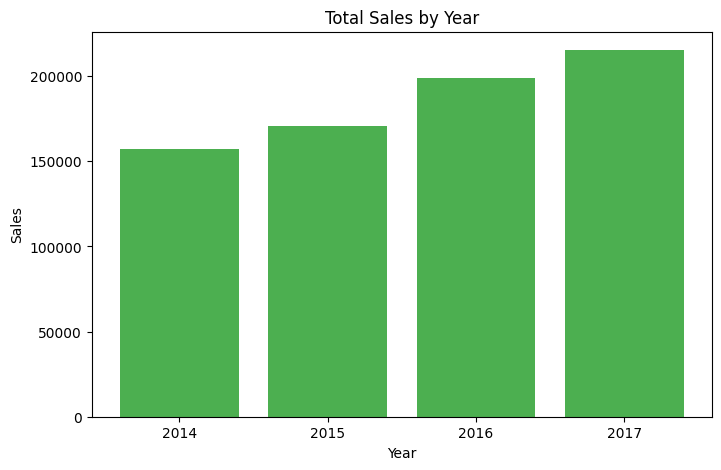

In [20]:
# ploting Total sale by year 

df['Year'] = df['Order Date'].dt.year
sales_by_year = df.groupby('Year')['Sales'].sum().reset_index()

plt.figure(figsize=(8,5))
plt.bar(sales_by_year['Year'], sales_by_year['Sales'], color='#4CAF50')
plt.title("Total Sales by Year")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.xticks(sales_by_year['Year'])
plt.show()


###  Total Sales by Year
This bar chart shows the total annual sales from 2014 to 2017.

Consistent Growth:  Sales have steadily increased each year, indicating positive business growth or improved customer engagement.

From 2014 to 2017, total sales rose from approximately 160,000 to over 215,000, reflecting a 34% increase over the 4-year period.

The sharpest growth appears between 2015 and 2016, suggesting a possible business expansion, successful promotion, or improved sales strategy during that time.

The clear upward trend in yearly sales supports the use of forecasting models, as it suggests a predictable and scalable sales pattern worth modeling for future planning and inventory management.

In [22]:
# create date month and group sales by month 
df['Month'] = df['Order Date'].dt.month
df['Year_Month'] = df['Order Date'].dt.to_period('M').astype(str)
sales_by_month = df.groupby('Month')['Sales'].sum().reset_index()
sales_by_year_month = df.groupby('Year_Month')['Sales'].sum().reset_index()




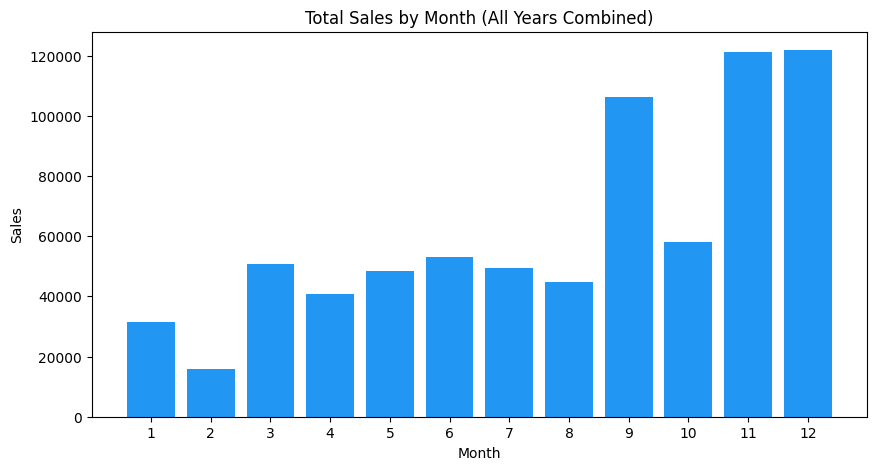

In [23]:
# plot total Sales by month (All years combined)
plt.figure(figsize=(10,5))
plt.bar(sales_by_month['Month'], sales_by_month['Sales'], color='#2196F3')
plt.title("Total Sales by Month (All Years Combined)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(sales_by_month['Month'])
plt.show()


### Total Sales by Month (All Years Combined)

This bar chart aggregates total sales across all years by calendar month, revealing **seasonal patterns** in consumer behavior.


* **November and December** show the highest sales volumes, indicating strong year-end performance, likely due to:

  * Black Friday / Cyber Monday promotions
  * Holiday shopping and gift-related spending
* **September** also sees a significant sales peak, which could relate to:

  * Back-to-school purchases
  * End-of-quarter inventory movements
* **February** shows the lowest sales, potentially due to:

  * Fewer calendar days
  * Post-holiday consumer fatigue

There is a clear seasonal pattern, with sales peaking in Q4 and dipping in Q1. This insight is valuable for:
* Strategic promotion timing
* Inventory stocking decisions
* Accurate time series forecasting

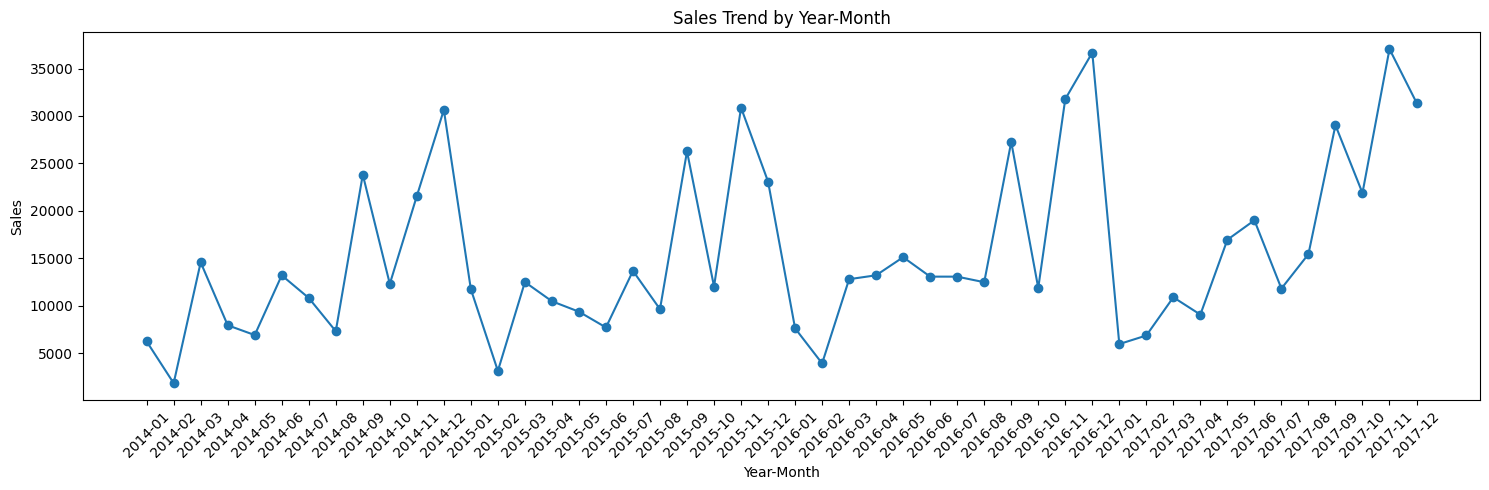

In [25]:
# plot Sales Trend by year-month
plt.figure(figsize=(15,5))
plt.plot(sales_by_year_month['Year_Month'], sales_by_year_month['Sales'], marker='o')
plt.title("Sales Trend by Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Sales Trend by Year-Month
This line chart shows the monthly sales trend over time from January 2014 to December 2017.


Consistent Year-End Peaks: Each year shows noticeable spikes in October, November, and December, confirming strong Q4 seasonality, likely due to:

Black Friday / Cyber Monday

Holiday shopping

End-of-year promotions

Recurring Dips in Early Months: Sales typically drop in January and February, reflecting post-holiday slowdowns or reduced consumer spending.

Upward Trend Over Time:

While there is month-to-month volatility, the overall trend increases, especially visible from 2016 onward.

This indicates business growth or expanding customer base.

Highest Spikes: Late 2016 and 2017 exhibit the most significant peaks, suggesting successful campaigns or increased operational scale during those periods.

This chart confirms both seasonality and a positive long-term growth trend, making the dataset ideal for time series forecasting using models like Prophet.

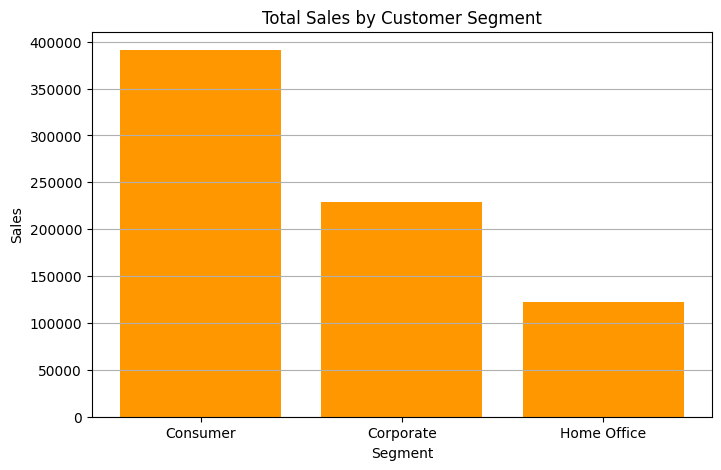

In [27]:
# Plot of total sales by conumer segment
sales_by_segment = df.groupby('Segment')['Sales'].sum().reset_index()

plt.figure(figsize=(8,5))
plt.bar(sales_by_segment['Segment'], sales_by_segment['Sales'], color='#FF9800')
plt.title("Total Sales by Customer Segment")
plt.xlabel("Segment")
plt.ylabel("Sales")
plt.grid(axis='y')
plt.show()


##### Total Sales by Customer Segment
This bar chart shows the cumulative sales performance across three customer segments:

 Consumer segment leads with the highest total sales of nearly 390,000, indicating it is the primary driver of revenue.

 Corporate customers contribute approximately 230,000, making it the second-largest segment, though significantly lower than Consumer.

 Home Office generates the least revenue, at around 120,000, suggesting lower volume or value per transaction.

The Consumer segment should be prioritized in future forecasting models due to its dominant share.

The Corporate segment still holds significant value and might benefit from targeted sales strategies.

The Home Office segment shows potential for growth, and forecasting sales here can identify opportunities for better engagement

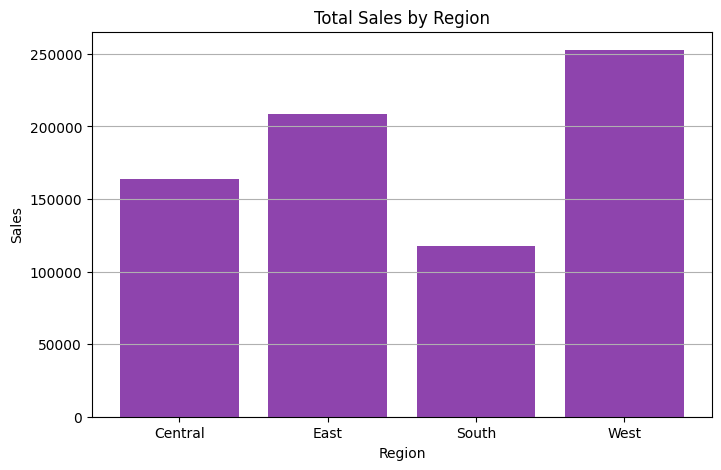

In [29]:
# Total sales by Region
sales_by_region = df.groupby('Region')['Sales'].sum().reset_index()

plt.figure(figsize=(8,5))
plt.bar(sales_by_region['Region'], sales_by_region['Sales'], color='#8E44AD')
plt.title("Total Sales by Region")
plt.xlabel("Region")
plt.ylabel("Sales")
plt.grid(axis='y')
plt.show()


#### Total Sales by Region
This bar chart illustrates the total sales generated across four geographical regions:

 West is the top-performing region, generating over 250,000 in sales,  making it a strong candidate for future focused investment and forecasting.

 East follows with around 210,000, also indicating healthy demand and solid regional performance.

 Central brings in approximately 165,000, which is moderate but behind the leading regions.

 South ranks lowest, with sales just above 115,000, suggesting either lower customer activity or untapped potential.

The West and East regions are the most lucrative and should be prioritized in sales forecasting and marketing strategies.

The South region may benefit from targeted campaigns or an operational review to improve performance.

Regional forecasting models could reveal seasonality or saturation differences across locations.

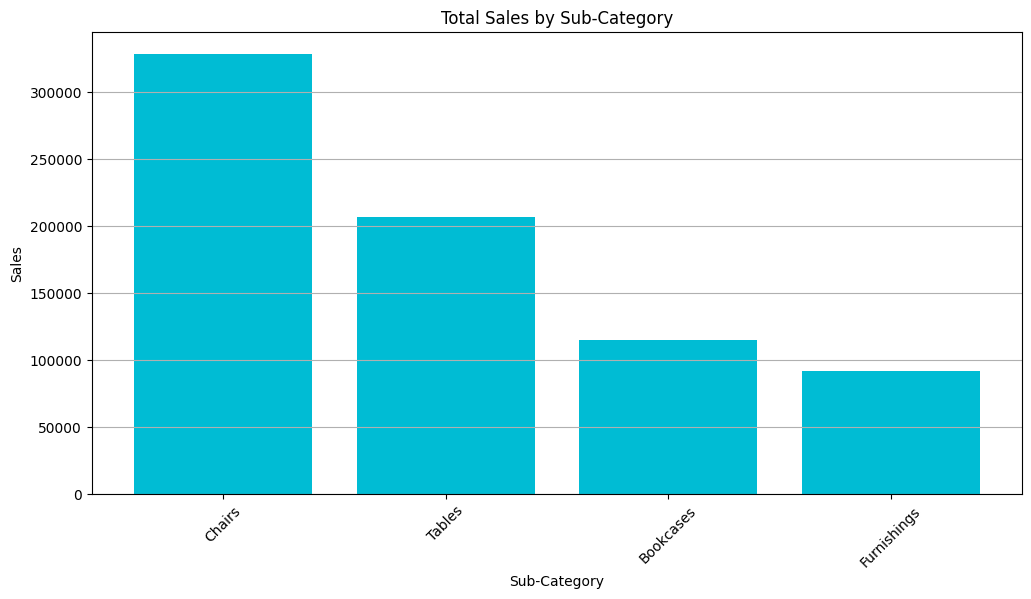

In [31]:
#total Sales by sub category
sales_by_subcat = df.groupby('Sub-Category')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(sales_by_subcat['Sub-Category'], sales_by_subcat['Sales'], color='#00BCD4')
plt.title("Total Sales by Sub-Category")
plt.xlabel("Sub-Category")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# Total Sales by Sub-Category
This chart shows the sales performance of four furniture-related sub-categories:

Chairs generate the highest sales overall, exceeding 325,000, making them the top-selling sub-category.

Tables follow as the second-largest contributor with around 210,000 in sales.

Bookcases and Furnishings trail behind, with sales just above 115,000 and 90,000, respectively.

Chairs should be prioritized for forecasting, inventory planning, and promotional efforts due to their dominant market share.

Furnishings, despite being a part of the same product family, perform the weakest, possibly due to lower demand or under-promotion.

A clear sales gap between the top (Chairs) and bottom (Furnishings) suggests different pricing strategies or customer preferences.

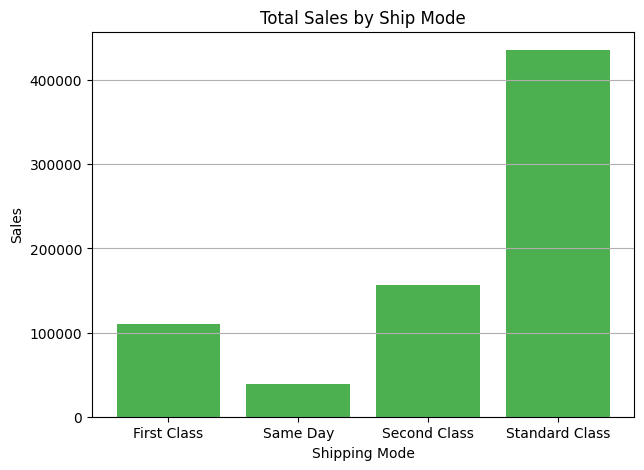

In [33]:
# Total sales by ship mode
sales_by_ship = df.groupby('Ship Mode')['Sales'].sum().reset_index()

plt.figure(figsize=(7,5))
plt.bar(sales_by_ship['Ship Mode'], sales_by_ship['Sales'], color='#4CAF50')
plt.title("Total Sales by Ship Mode")
plt.xlabel("Shipping Mode")
plt.ylabel("Sales")
plt.grid(axis='y')
plt.show()


####  Total Sales by Shipping Mode
This bar chart shows the total sales associated with different shipping methods:

Standard Class is the dominant shipping method, generating over $430,000 in sales — likely due to its affordability and widespread customer preference.

Second Class and First Class follow with moderate sales levels, contributing roughly 160,000 and $110,000, respectively.

Same-day shipping brings in the least revenue (around $40,000), indicating it’s either underutilized or limited to niche or urgent orders.


Standard Class is the preferred option for most customers and is likely used in the bulk of online purchases.

Same-day shipping may not be a significant sales driver — possibly due to higher costs, limited product availability, or geographic restrictions.

Retailers could explore if up-selling faster shipping options (e.g., First Class) boosts customer satisfaction or average order value.



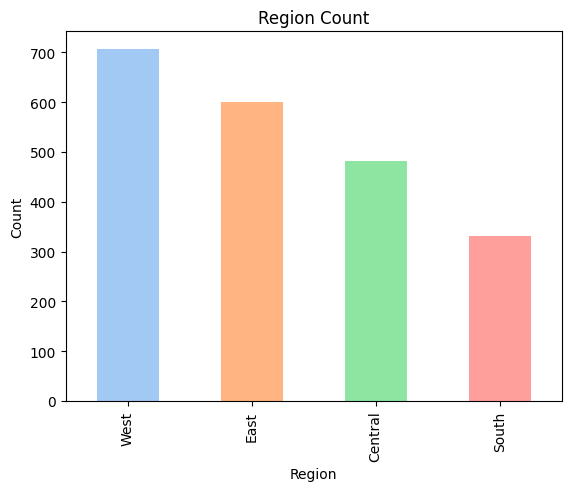

In [35]:
# plot of Region count
colors = sns.color_palette('pastel')

# Plot the bar chart with custom colors
df.Region.value_counts().plot(kind="bar", color=colors)

# Add titles and labels for clarity 
plt.title("Region Count")
plt.xlabel("Region")
plt.ylabel("Count")

# Display the plot
plt.show()

#### Region Count (Number of Transactions per Region)
This bar chart represents the number of transactions or entries recorded for each region:

 The West region has the highest transaction count (over 700), suggesting it is the most active or frequently served market.

 East follows closely with around 600 records.

 The centrall region has moderate activity, just under 500.

 South has the lowest number of transactions, around 330, indicating lower sales volume or customer engagement.


High transaction volume in the West and East aligns with earlier insights about them being top sales-generating regions.

The South region not only had the lowest total sales but also the fewest transactions, reinforcing it as a low-activity zone that may need intervention.

Transaction volume often correlates with demand, market size, or regional sales team performance — making this insight useful for resource allocation and forecasting segmentation.

Text(0.5, 1.0, 'Profit vs Sales')

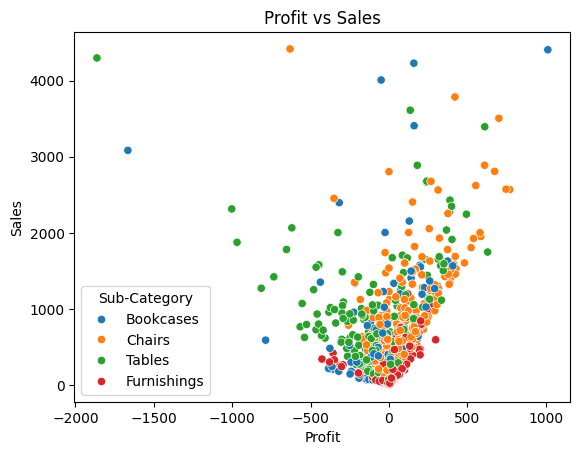

In [52]:
# plot of Profit vs Sales
sns.scatterplot(data=df, y='Sales',x='Profit', hue="Sub-Category")
plt.title("Profit vs Sales")


#### Profit vs Sales by Sub-Category

This scatter plot illustrates the relationship between profit and sales across four furniture sub-categories:

Most data points cluster around low to moderate sales and profits, indicating that many transactions involve smaller-scale purchases.

Chairs (orange) and Tables (green) dominate the higher-sales range, but also show several instances of negative profit, suggesting potential issues like discounting, returns, or high costs.

Bookcases (blue) have a wide spread, including some extreme loss-making sales with high negative profit, making them a risk-prone category.

Furnishings (red) cluster tightly at lower sales and profits, appearing less volatile but also less lucrative.


High Sales do not equal High Profit: Many high-sales entries still result in losses, especially in the Chairs and Bookcases categories.

Watch Bookcases: They show some of the largest negative profit margins and warrant cost analysis or pricing review.

Target Tables and Chairs for profit optimization — they have potential but need better margin control.

Furnishings are stable but generate lower revenue and profit overall.



In [55]:
# Total sales per State
state_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False)
# Total sales per City
city_sales = df.groupby('City')['Sales'].sum().sort_values(ascending=False)




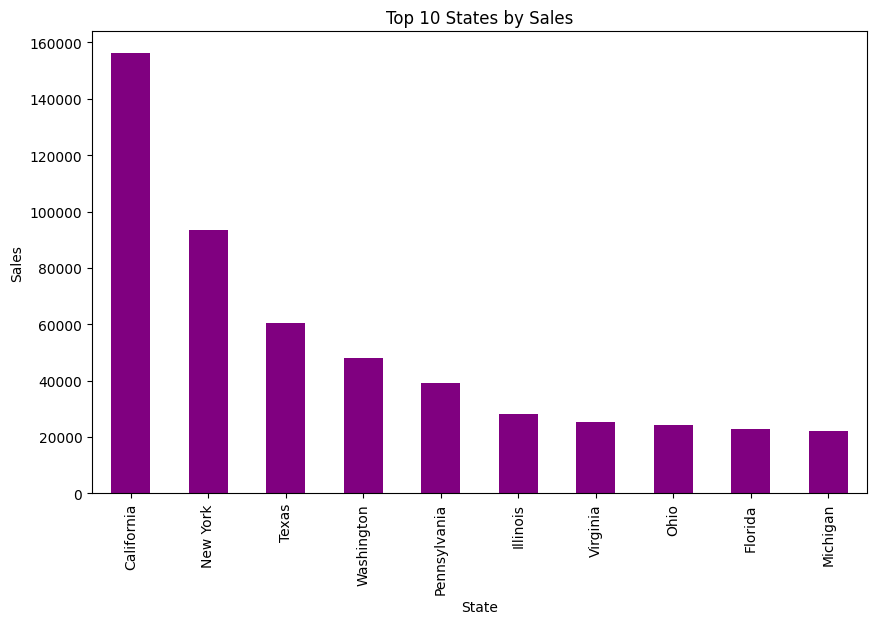

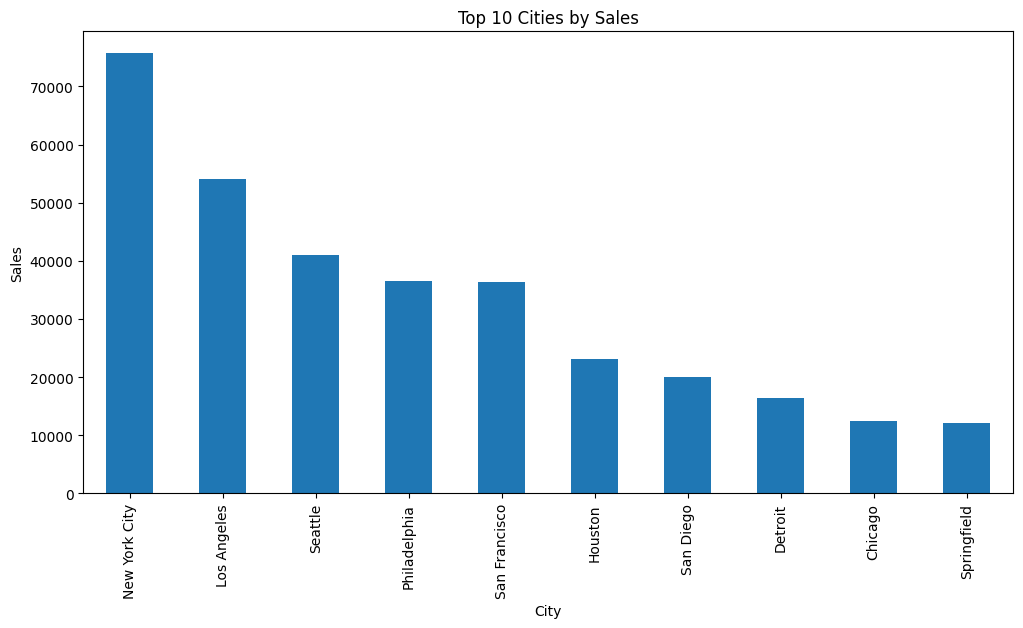

In [22]:

# Top 10 states
top_states = state_sales.head(10)
top_states.plot(kind='bar', figsize=(10,6), title='Top 10 States by Sales',color='purple')
plt.ylabel('Sales')
plt.show()

# Top 10 cities
top_cities = city_sales.head(10)
top_cities.plot(kind='bar', figsize=(12,6), title='Top 10 Cities by Sales')
plt.ylabel('Sales')
plt.show()



#### Top 10 States by Sales
This chart displays the ten U.S. states with the highest total sales, providing insights into key market contributors.

Top Performers:
California stands out significantly, with sales exceeding $150,000, making it the largest revenue-generating state by a wide margin.

New York follows with approximately 94,000, and Texas with around 61,000, showing strong market activity.

Moderate Contributors:
Washington and Pennsylvania make up the mid-tier, contributing between $39,000–$49,000 each.

Lower of the Top 10:
Illinois, Virginia, Ohio, Florida, and Michigan all contribute sales in the $22,000–$30,000 range.

California is a clear sales leader, and strategies like inventory planning and customer targeting should be tailored to its high demand.

The chart indicates that the top 3 states contribute disproportionately to total sales — ideal for region-focused forecasting.

The tail-end states like Michigan and Florida, while still in the top 10, may offer room for marketing or outreach expansion to boost performance.



#### Top 10 Cities by Sales
This chart displays the cities with the highest total sales, highlighting major urban centers that drive business revenue.

High-Performing Cities:
New York City leads all cities with over $75,000 in sales, standing out as the most profitable urban market.

Los Angeles follows with about $54,000, confirming California’s dominant presence in state- and city-level sales.

Seattle and Philadelphia also show strong performance, both exceeding $35,000–$40,000 in sales.

Mid-Tier Contributors:
San Francisco, Houston, and San Diego make up the mid-tier, each contributing $20,000–$36,000 in sales.

 Lower of the Top 10:
Detroit, Chicago, and Springfield round out the bottom, each recording $12,000–$17,000.


Urban hubs like New York City and Los Angeles are critical markets and should be key targets for forecasting, marketing, and supply chain planning.

The wide gap between the top 3 and bottom 3 cities shows potential for sales expansion strategies in underserved cities like Chicago and Springfield.

Geographic city-level insights help refine local-level resource allocation and campaign targeting.



C:\Users\adjei\AppData\Local\Temp\ipykernel_8972\3289391444.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.index, y=top_products.values, palette='coolwarm')


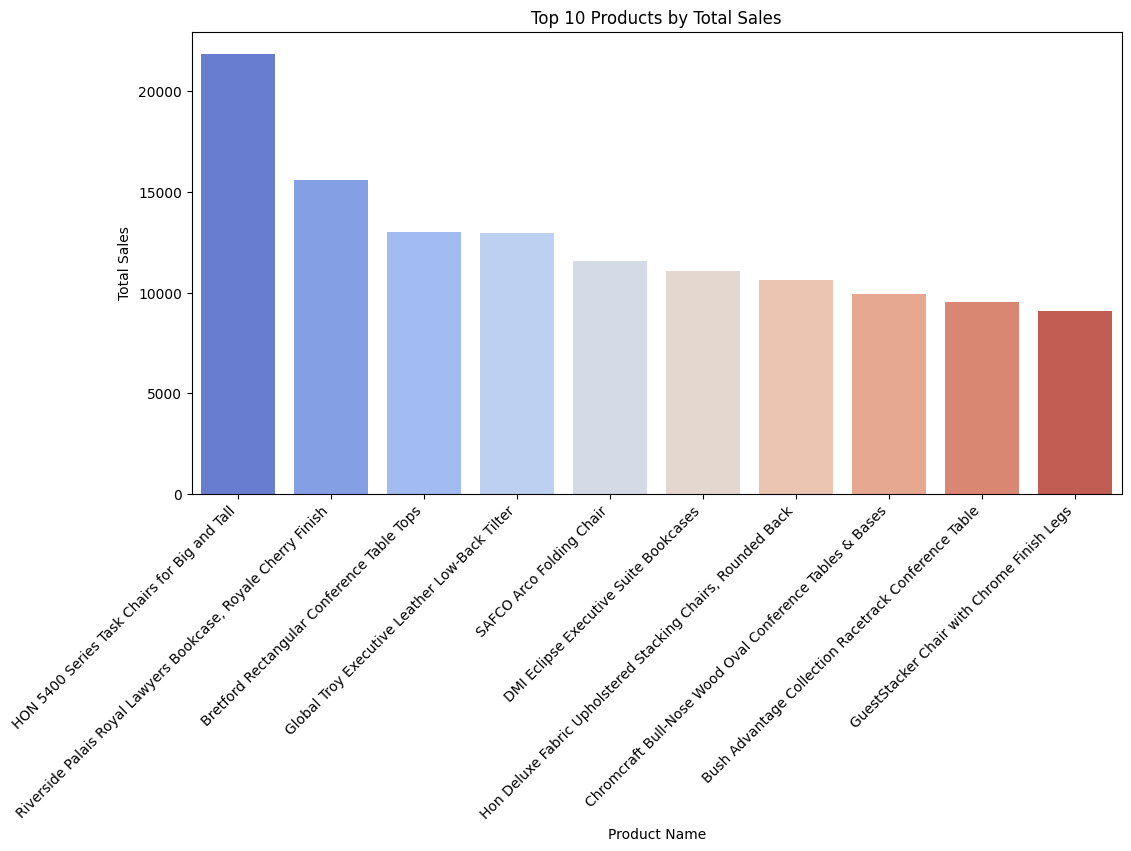

In [23]:
# Sort products by total sales
top_products = df.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.index, y=top_products.values, palette='coolwarm')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Product Name')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Top 10 Products by Total Sales
This bar chart showcases the 10 best-selling products based on total revenue, providing valuable insights into high-performing items in the catalog.

 Top Performers:
HON 5400 Series Task Chairs for Big and Tall dominate the chart with sales surpassing $21,000, indicating it is the most popular and profitable product.

Riverside Palais Royal Lawyers Bookcase and Bretford Rectangular Conference Table Tops follow, generating between $13,000–$15,500.

Mid-Performing Products:
Products like the Global Troy Executive Leather Low-Back Tilter, SAFCO Arco Folding Chair, and DMI Eclipse Executive Suite Bookcases contribute steadily to total sales, each in the $11,000–$13,000 range.

Lower Tier (of Top 10):
The Chromcraft Bull-Nose Wood Oval Conference Tables and GuestStacker Chair with Chrome Finish Legs are still within the top 10 but show lower sales (9,000–10,000), signaling a drop-off in demand compared to the top products.


The product mix is chair-heavy, showing that seating solutions dominate customer preferences.

The top 3 products alone contribute a large portion of total product revenue — suggesting these items should be prioritized in inventory planning and promotional strategies.

Consistent sales across diverse furniture types (chairs, bookcases, tables) indicate a balanced product demand across categories.

Correlation between Discount and Profit: -0.48


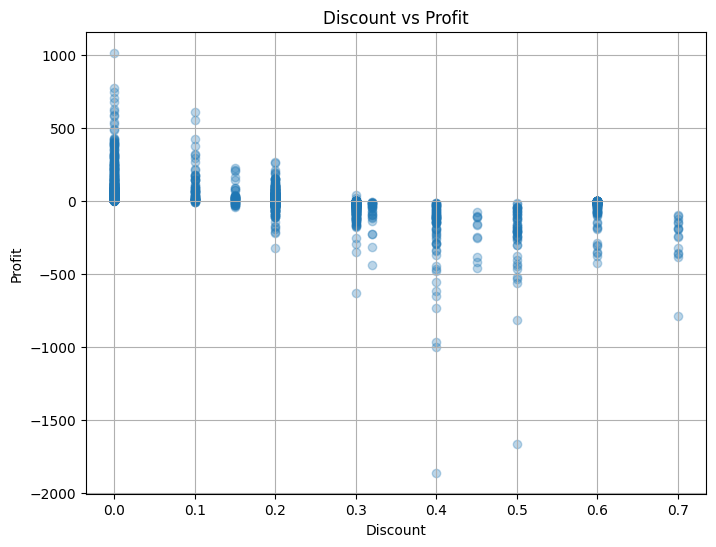

In [26]:
# Plot of Discount vs profit
correlation = df['Discount'].corr(df['Profit'])
print(f"Correlation between Discount and Profit: {correlation:.2f}")

plt.figure(figsize=(8,6))
plt.scatter(df['Discount'], df['Profit'], alpha=0.3)
plt.title("Discount vs Profit")
plt.xlabel("Discount")
plt.ylabel("Profit")
plt.grid(True)
plt.show()


Discount vs Profit

This scatter plot illustrates the relationship between the discount percentage given on products and the resulting profit.

Zero Discount = Higher Profit
Points clustered around a 0% discount show mostly positive profit, indicating that full-priced sales tend to be profitable.

Increasing Discount = Declining Profit
As the discount increases (e.g., 20%–70%), the profit values decrease, often becoming negative.
This implies that high discounts are eroding profits and, in many cases, resulting in losses.

Loss Zones
Several data points around 30%–60% discount correspond to large losses, some below −1000, indicating steep discounts are financially unsustainable for some products.

There is a clear negative correlation between discount and profit. This suggests that while discounts may drive sales volume, they often do so at the cost of profitability.

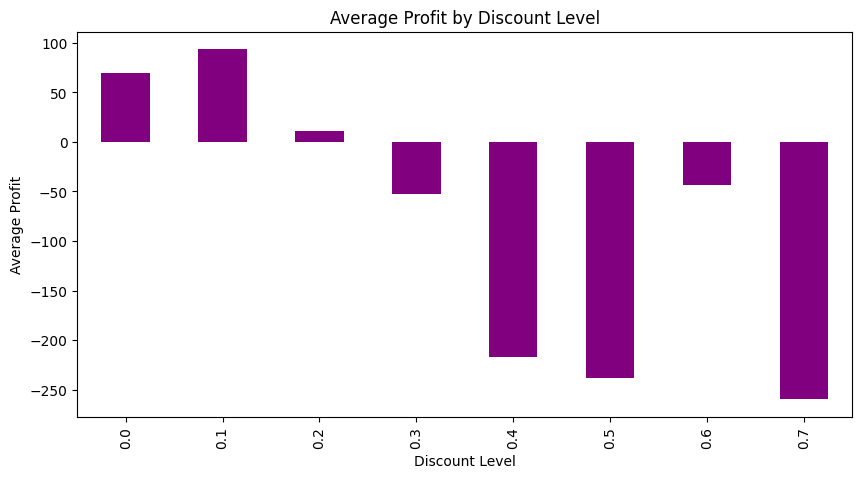

In [27]:
# Round discount to nearest 0.1 (10%) for grouping
df['Discount_Bucket'] = df['Discount'].round(1)

avg_profit = df.groupby('Discount_Bucket')['Profit'].mean()

avg_profit.plot(kind='bar', figsize=(10,5), title='Average Profit by Discount Level',color= 'purple')
plt.ylabel('Average Profit')
plt.xlabel('Discount Level')
plt.show()


#### Average Profit by Discount Level
This bar chart visualizes how average profit varies with different discount percentages applied to sales.


0.0 to 0.1 (0%–10%) Discounts:

These levels generate the highest average profits.

A 10% discount yields the peak average profit—the most profitable range.

0.2 (20%) Discount:

Slight dip in average profit, signaling diminishing returns from higher discounts.

≥ 0.3 (30% and above):

Profits turn negative, with increasing losses as discounts increase.

70% discount leads to the lowest average profit, suggesting deep discounts may be unsustainable.

Maintaining discounts at 10% or lower is financially advantageous. Applying discounts beyond 30% severely reduces profitability and should be used cautiously or strategically

In [28]:
# Profit 
product_stats = df.groupby('Product Name').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Units_Sold=('Quantity', 'sum')
).reset_index()


In [29]:
# Threshold for high sales (e.g., top 20%)
units_sold_threshold = product_stats['Units_Sold'].quantile(0.8)

# Filter for high sales, low or negative profit
bad_products = product_stats[
    (product_stats['Units_Sold'] >= units_sold_threshold) &
    (product_stats['Total_Profit'] <= 0)
].sort_values(by='Total_Sales', ascending=False)


In [30]:
print("Products that sell a lot but do not earn profit:")
print(bad_products[['Product Name', 'Units_Sold', 'Total_Sales', 'Total_Profit']])

#  save to CSV
# bad_products.to_csv("unprofitable_high_sellers.csv", index=False)


Products that sell a lot but do not earn profit:
                                          Product Name  Units_Sold  \
40          Bretford Rectangular Conference Table Tops          46   
42   Bush Advantage Collection Racetrack Conference...          33   
66                  Chromcraft Round Conference Tables          61   
222                      Hon 94000 Series Round Tables          30   
29                 Bevis Oval Conference Table, Walnut          36   
186          Global High-Back Leather Tilter, Burgundy          54   
65            Chromcraft Rectangular Conference Tables          30   
210                  High-Back Leather Manager's Chair          42   
257                         KI Adjustable-Height Table          74   
204    Global Wood Trimmed Manager's Task Chair, Khaki          59   
308  Office Star - Contemporary Task Swivel chair w...          35   
49   Bush Heritage Pine Collection 5-Shelf Bookcase...          34   
256               Iceberg OfficeWorks 42"

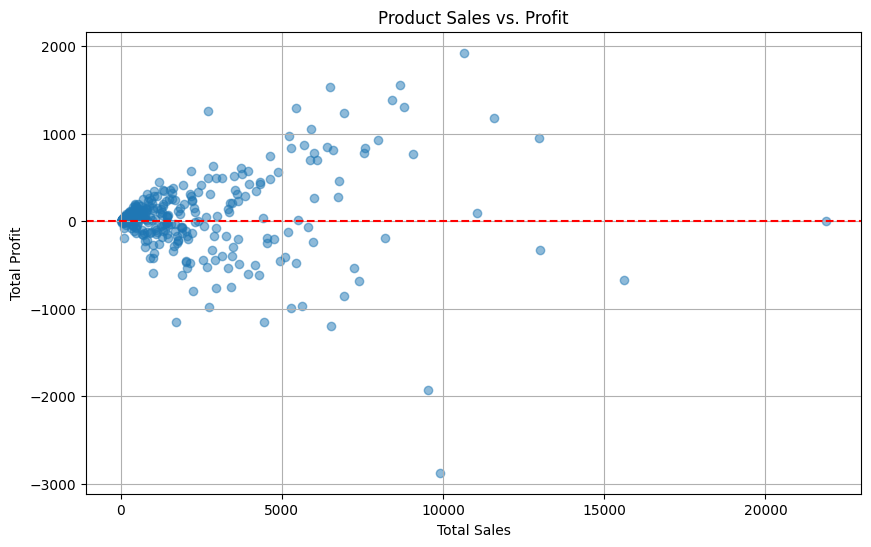

In [31]:
# plot of product sales vs profit
plt.figure(figsize=(10,6))
plt.scatter(product_stats['Total_Sales'], product_stats['Total_Profit'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Profit threshold
plt.xlabel("Total Sales")
plt.ylabel("Total Profit")
plt.title("Product Sales vs. Profit")
plt.grid(True)
plt.show()


#### Product Sales vs. Profit
This scatter plot displays the relationship between total sales and total profit for various products. A red dashed horizontal line at y = 0 highlights the break-even point.


Most products are clustered at lower sales values, with varied profitability.

Some products with high sales volumes still incur losses, indicating possible over-discounting or low-margin pricing.

Products above the red line are profitable, while those below it are loss-making.

The spread of data suggests that high sales don't always guarantee high profits.


To optimize profitability, it's not enough to push for high sales; profit margins must be monitored closely. This visualization helps identify high-volume yet unprofitable items that may need pricing or discount adjustments.



In [32]:
#Investigate why: High discounts? High cost? Shipping issues?

In [33]:
# Merge bad_products with original df to analyze discounts for those products
bad_product_names = bad_products['Product Name']
discount_stats = df[df['Product Name'].isin(bad_product_names)].groupby('Product Name')['Discount'].mean()

# Add this to your bad_products DataFrame
bad_products = bad_products.merge(discount_stats, on='Product Name', how='left')
bad_products = bad_products.rename(columns={'Discount': 'Avg_Discount'})

print(bad_products[['Product Name', 'Units_Sold', 'Total_Sales', 'Total_Profit', 'Avg_Discount']])


                                         Product Name  Units_Sold  \
0          Bretford Rectangular Conference Table Tops          46   
1   Bush Advantage Collection Racetrack Conference...          33   
2                  Chromcraft Round Conference Tables          61   
3                       Hon 94000 Series Round Tables          30   
4                 Bevis Oval Conference Table, Walnut          36   
5           Global High-Back Leather Tilter, Burgundy          54   
6            Chromcraft Rectangular Conference Tables          30   
7                   High-Back Leather Manager's Chair          42   
8                          KI Adjustable-Height Table          74   
9     Global Wood Trimmed Manager's Task Chair, Khaki          59   
10  Office Star - Contemporary Task Swivel chair w...          35   
11  Bush Heritage Pine Collection 5-Shelf Bookcase...          34   
12               Iceberg OfficeWorks 42" Round Tables          30   
13         O'Sullivan 4-Shelf Book

#### Underperforming Products Analysis
The following table highlights products that generated losses despite sales activity. Each row includes:

Product Name

Units Sold

Total Sales

Total Profit

Average Discount offered on the product

This insight allows us to identify products that may be over-discounted, underpriced, or inherently unprofitable.

Observations:
Most products listed had negative total profit, despite selling several units.

For example:

Bush Advantage Collection Racetrack Conference Table sold 33 units with sales of ₵9,544.73, yet incurred a loss of ₵1,934.40, with an average discount of 35%.

Bretford Rectangular Conference Table Tops sold 46 units but still led to a ₵327.23 loss.

Many of these products have average discounts of over 20–40%, suggesting that heavy discounting may be driving the unprofitability.

Notably, the Global Super Steno Chair had zero net profit with an extremely small margin, making it a break-even item despite reasonable sales.

#### Recommendations:
Review the pricing strategy for these products.

Consider reducing discount levels or negotiating supplier costs.

These insights can guide strategic decisions on product promotions, pricing, and inventory management.

In [34]:
delivery_stats = df[df['Product Name'].isin(bad_product_names)].groupby('Product Name')['Delivery_Days'].mean()
bad_products = bad_products.merge(delivery_stats, on='Product Name', how='left')
bad_products = bad_products.rename(columns={'Delivery_Days': 'Avg_Delivery_Days'})

print(bad_products[['Product Name', 'Avg_Discount', 'Avg_Delivery_Days']])


                                         Product Name  Avg_Discount  \
0          Bretford Rectangular Conference Table Tops      0.245833   
1   Bush Advantage Collection Racetrack Conference...      0.350000   
2                  Chromcraft Round Conference Tables      0.257692   
3                       Hon 94000 Series Round Tables      0.160000   
4                 Bevis Oval Conference Table, Walnut      0.275000   
5           Global High-Back Leather Tilter, Burgundy      0.185714   
6            Chromcraft Rectangular Conference Tables      0.322222   
7                   High-Back Leather Manager's Chair      0.166667   
8                          KI Adjustable-Height Table      0.236111   
9     Global Wood Trimmed Manager's Task Chair, Khaki      0.228571   
10  Office Star - Contemporary Task Swivel chair w...      0.188889   
11  Bush Heritage Pine Collection 5-Shelf Bookcase...      0.233750   
12               Iceberg OfficeWorks 42" Round Tables      0.200000   
13    

In [35]:
shipping_mode_counts = df[df['Product Name'].isin(bad_product_names)].groupby('Product Name')['Ship Mode'].agg(lambda x: x.value_counts().index[0])
bad_products = bad_products.merge(shipping_mode_counts, on='Product Name', how='left')
bad_products = bad_products.rename(columns={'Ship Mode': 'Most_Common_Ship_Mode'})

print(bad_products[['Product Name', 'Most_Common_Ship_Mode']])


                                         Product Name Most_Common_Ship_Mode
0          Bretford Rectangular Conference Table Tops        Standard Class
1   Bush Advantage Collection Racetrack Conference...        Standard Class
2                  Chromcraft Round Conference Tables        Standard Class
3                       Hon 94000 Series Round Tables        Standard Class
4                 Bevis Oval Conference Table, Walnut        Standard Class
5           Global High-Back Leather Tilter, Burgundy        Standard Class
6            Chromcraft Rectangular Conference Tables        Standard Class
7                   High-Back Leather Manager's Chair        Standard Class
8                          KI Adjustable-Height Table        Standard Class
9     Global Wood Trimmed Manager's Task Chair, Khaki        Standard Class
10  Office Star - Contemporary Task Swivel chair w...        Standard Class
11  Bush Heritage Pine Collection 5-Shelf Bookcase...           First Class
12          

In [36]:
print(bad_products[['Product Name', 'Units_Sold', 'Total_Sales', 'Total_Profit', 'Avg_Discount', 'Avg_Delivery_Days', 'Most_Common_Ship_Mode']])


                                         Product Name  Units_Sold  \
0          Bretford Rectangular Conference Table Tops          46   
1   Bush Advantage Collection Racetrack Conference...          33   
2                  Chromcraft Round Conference Tables          61   
3                       Hon 94000 Series Round Tables          30   
4                 Bevis Oval Conference Table, Walnut          36   
5           Global High-Back Leather Tilter, Burgundy          54   
6            Chromcraft Rectangular Conference Tables          30   
7                   High-Back Leather Manager's Chair          42   
8                          KI Adjustable-Height Table          74   
9     Global Wood Trimmed Manager's Task Chair, Khaki          59   
10  Office Star - Contemporary Task Swivel chair w...          35   
11  Bush Heritage Pine Collection 5-Shelf Bookcase...          34   
12               Iceberg OfficeWorks 42" Round Tables          30   
13         O'Sullivan 4-Shelf Book

#### Average Discount and Delivery Days for Underperforming Products
This table summarizes the average discount levels and average delivery times for products that resulted in a net loss (negative profit). Here's what we can conclude:
 High Discounts Often Lead to Losses:

Many of these products were sold with average discounts above 20%.

Products like:

Bush Advantage Collection Racetrack Conference Table (35% discount),

O'Sullivan 4-Shelf Bookcase in Odessa Pine (42% discount), and

KI Conference Tables (32% discount)
suffered from significantly negative profits.

Implication: High discounting strategies can erode profitability, especially for expensive or bulky items like conference tables and bookcases.

Delivery Times Don’t Vary Much, But Slightly Longer for Top Losses:

The average delivery time across products ranged from ~3.1 to ~5.1 days.

Bush Advantage Collection Racetrack Conference Table, one of the worst-performing items, also had one of the longest delivery times (5.14 days).

While delivery days aren’t as clearly tied to loss as discounts, longer delivery might affect customer satisfaction and reorder rates.

 Product Type Insight:

Most of the underperforming products are furniture items – including chairs, tables, bookcases, and conference equipment.

These are often heavier, have higher shipping and handling costs, and may have lower margin flexibility.


High discount levels appear to be a primary contributor to negative profitability. While delivery times vary only slightly, combining high discounts with longer delivery times might be affecting overall customer value and operational efficiency.

A potential next step could be to re-evaluate discount strategies for specific products and optimize logistics for bulky items to improve profit margins.

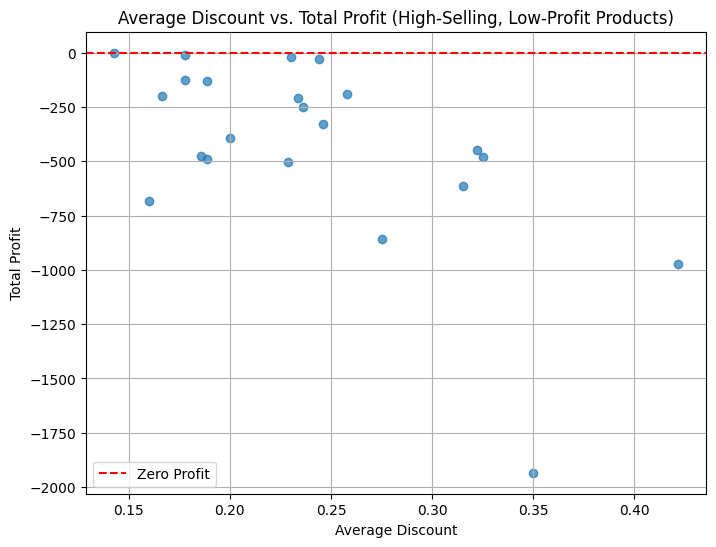

In [37]:
# Averagwe Discount vs Total Profit (High selling, low proit-products)
plt.figure(figsize=(8,6))
plt.scatter(bad_products['Avg_Discount'], bad_products['Total_Profit'], alpha=0.7)
plt.xlabel('Average Discount')
plt.ylabel('Total Profit')
plt.title('Average Discount vs. Total Profit (High-Selling, Low-Profit Products)')
plt.axhline(0, color='red', linestyle='--', label='Zero Profit')
plt.grid(True)
plt.legend()
plt.show()


#### Average Discount vs. Total Profit — High-Selling, Low-Profit Products
This chart presents average discount levels on the x-axis and total profit on the y-axis for products that are selling well but earning poor or negative profit.


All data points are below the red zero-profit line, indicating every product in the analysis is unprofitable, despite strong sales.

Higher discounts are associated with deeper losses:

Products offering discounts above 30% tend to have extreme losses (as low as -$1,800+).

Products with moderate discounts (15–25%) still mostly result in negative profits, suggesting that discounting alone is not a sustainable strategy for these items.

##### Business Insight:
This plot confirms that aggressive discounting is a major contributor to unprofitability among best-selling products. Even with strong unit sales, excessive price cuts erode profits entirely or push them into negative territory.

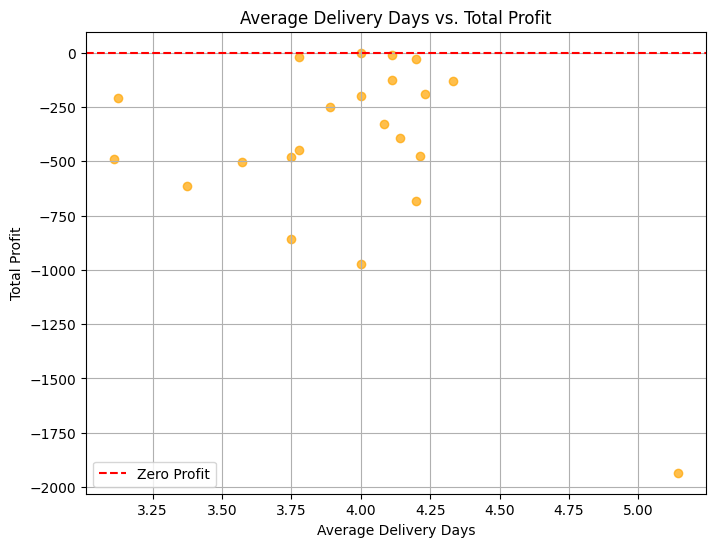

In [38]:
# Average Delivery Days vs Total profit
plt.figure(figsize=(8,6))
plt.scatter(bad_products['Avg_Delivery_Days'], bad_products['Total_Profit'], color='orange', alpha=0.7)
plt.xlabel('Average Delivery Days')
plt.ylabel('Total Profit')
plt.title('Average Delivery Days vs. Total Profit')
plt.axhline(0, color='red', linestyle='--', label='Zero Profit')
plt.grid(True)
plt.legend()
plt.show()


#### Average Delivery Days vs. Total Profit (High-Selling, Low-Profit Products)
This scatter plot shows the relationship between the average delivery time (in days) and the total profit for top-selling products that are yielding low or negative profits.

All products fall below the red “Zero Profit” line, meaning every item in this analysis is generating a loss.

Most products cluster around 3.5 to 4.3 delivery days, showing no major variation in delivery time.

Longer delivery days (e.g., 5+) appear to correspond with deeper losses, though not consistently across all data points.


While delivery time may not be the primary cause of unprofitability, longer delivery periods could be compounding customer dissatisfaction, especially when paired with low margins or high discounts. Even marginal delays may contribute to increased return rates or reduced customer lifetime value.

#### Recommendation:
Monitor and optimize delivery performance, especially for underperforming products.

Investigate whether products with delivery delays also suffer higher return rates or customer complaints.

Combine this insight with discount analysis for a more complete cost-control and profitability strategy.

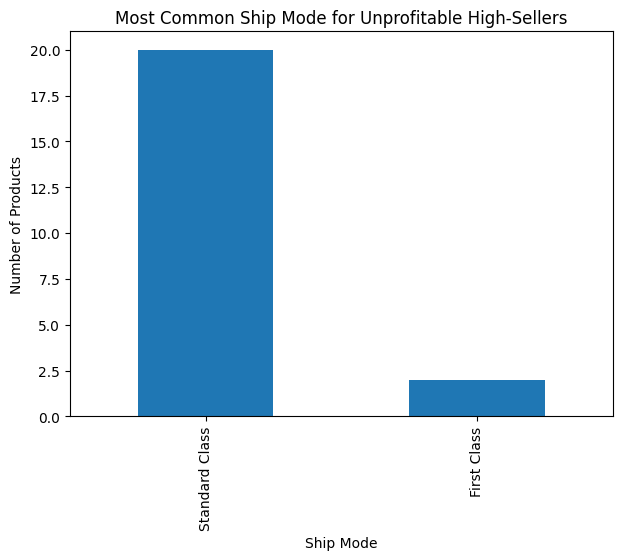

In [39]:
bad_products['Most_Common_Ship_Mode'].value_counts().plot(kind='bar', figsize=(7,5))
plt.title('Most Common Ship Mode for Unprofitable High-Sellers')
plt.xlabel('Ship Mode')
plt.ylabel('Number of Products')
plt.show()


#### Most Common Ship Mode for Unprofitable High-Sellers
This bar chart shows the distribution of shipping methods used for products that sold in high volumes but resulted in negative profit.


Standard Class shipping is overwhelmingly the most used mode among unprofitable high-selling products (20 out of 22).

First Class shipping is rarely used, appearing in just 2 cases.

The overreliance on Standard Class shipping suggests that either the shipping cost is too high relative to product margin or delivery speed isn't translating into higher profitability.

It’s also possible that longer delivery times from Standard Class are impacting customer satisfaction, especially if tied to heavily discounted products.

#### Recommendations:
Reevaluate Standard Class usage for low-margin, high-volume products. Could faster delivery improve profitability or customer retention?

Consider A/B testing First Class vs Standard Class for select items to assess profit impact.

Integrate this with earlier findings on discounts and delivery days to develop a more targeted fulfillment strategy.

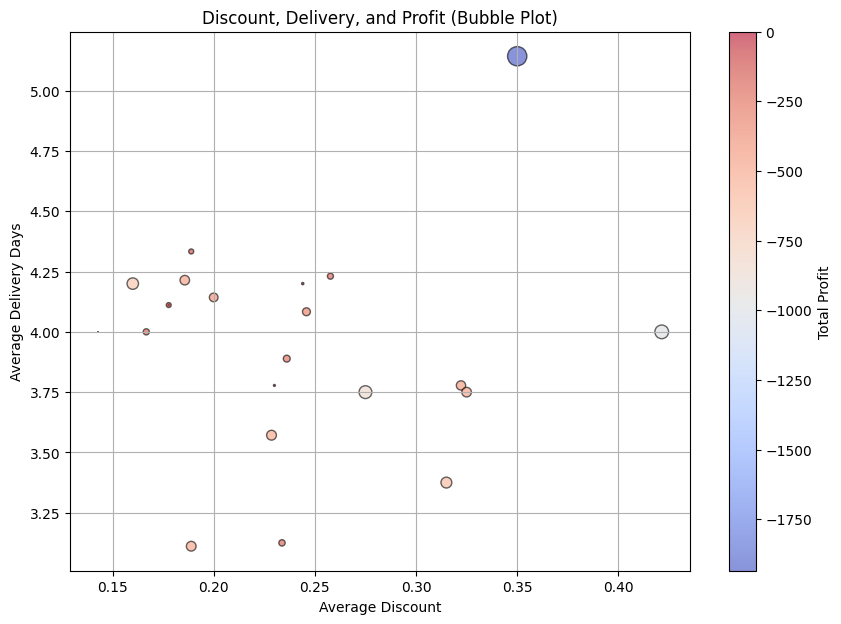

In [40]:
plt.figure(figsize=(10,7))
plt.scatter(
    bad_products['Avg_Discount'],
    bad_products['Avg_Delivery_Days'],
    s=abs(bad_products['Total_Profit'])/10,  # Bubble size, scale as needed
    c=bad_products['Total_Profit'],
    cmap='coolwarm',
    alpha=0.6,
    edgecolors='k'
)
plt.colorbar(label='Total Profit')
plt.xlabel('Average Discount')
plt.ylabel('Average Delivery Days')
plt.title('Discount, Delivery, and Profit (Bubble Plot)')
plt.grid(True)
plt.show()


#### Discount, Delivery, and Profit (Bubble Plot)
This bubble plot visualizes the interaction between:

- Average Discount (x-axis)

- Average Delivery Days (y-axis)

- Total Profit (bubble color and size)


- Color Intensity & Bubble Size = Profit

- Larger and bluer bubbles represent greater losses.

- Smaller and lighter (pink) bubbles represent less negative or near-zero profit.

High Discount → High Losses

Bubbles towards the right (high discounts) are mostly large and blue, confirming that high discounts are strongly associated with greater profit loss.

Delivery Days Impact

Products with longer average delivery days (y-axis above 4.5) and high discounts are more likely to be unprofitable, especially visible in the large blue bubble at the top-right.

Low Discount ≠ Guaranteed Profit

Even some products with lower discounts (~0.2) show negative profits, suggesting other factors like shipping mode, demand elasticity, or operational cost may contribute to losses.

Implications:
Balance needed: Simply reducing delivery time or discount isn't enough alone. A strategic balance is required between discount strategy and fulfillment performance.

Investigate outliers: Products with moderate discounts but high losses should be prioritized for cost or pricing review.

C:\Users\adjei\AppData\Local\Temp\ipykernel_8972\2904114955.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


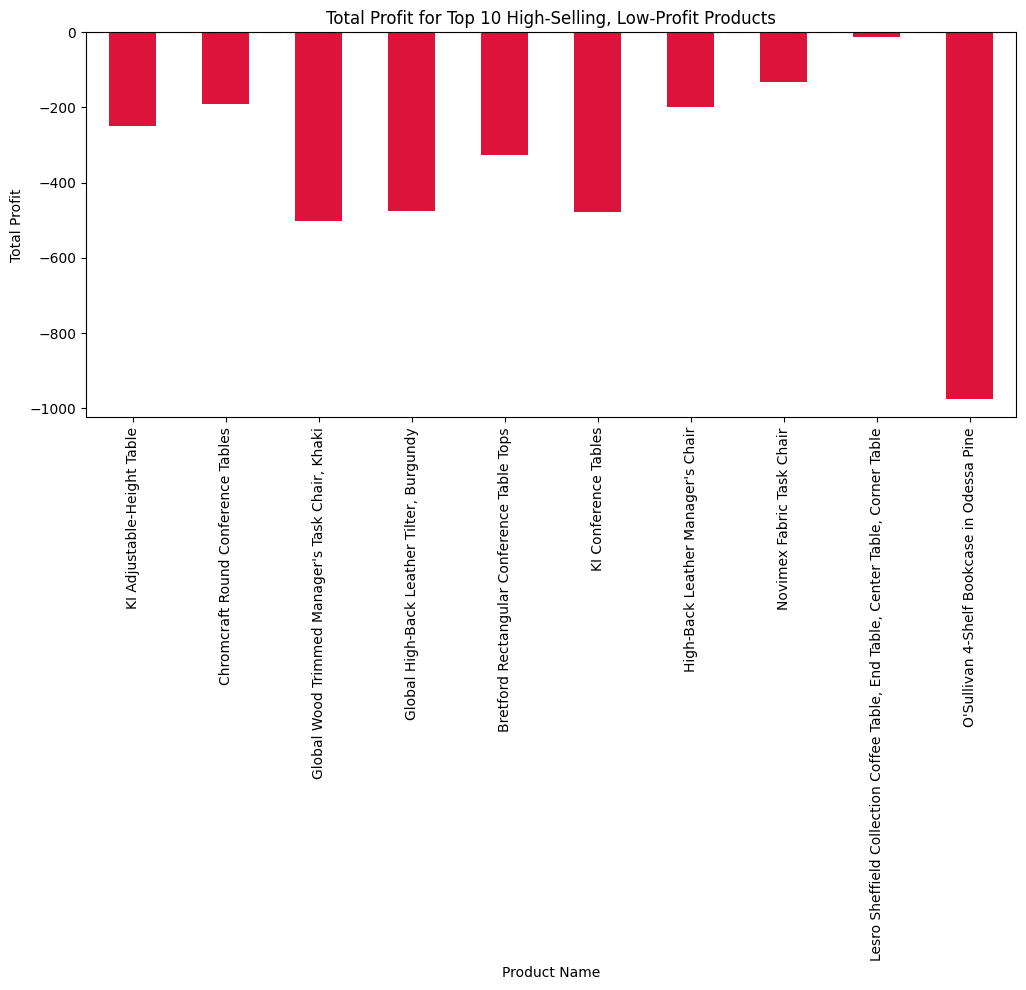

In [41]:
# Total Profit for top 10 high selling, low  profit products
top_bad = bad_products.sort_values('Units_Sold', ascending=False).head(10)
top_bad.set_index('Product Name')['Total_Profit'].plot(kind='bar', color='crimson', figsize=(12,5))
plt.title('Total Profit for Top 10 High-Selling, Low-Profit Products')
plt.ylabel('Total Profit')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


#### Total Profit for Top 10 High-Selling, Low-Profit Products
This bar chart highlights the total profit performance of the top 10 products that sold well but generated the lowest profits.


All products listed had negative profits, indicating that high sales volume does not guarantee profitability.

The worst-performing product in terms of total profit is:

O'Sullivan 4-Shelf Bookcase in Odessa Pine, with a loss of over 1000 units in profit.

Other consistently unprofitable items include:

KI Conference Tables

Bretford Rectangular Conference Table Tops

Global High-Back Leather Tilter, Burgundy

Despite differences in product type, a common trend appears: many are furniture or conference-related products, hinting that bulk discounts or high return/shipping costs might be driving the losses.



In [43]:
print("Overall delivery time stats:")
print(df['Delivery_Days'].describe())


Overall delivery time stats:
count    2121.000000
mean        3.917020
std         1.755234
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: Delivery_Days, dtype: float64


In [44]:
region_delay = df.groupby('Region')['Delivery_Days'].mean().sort_values(ascending=False)
print(region_delay)


Region
South      4.024096
Central    3.979210
West       3.881188
East       3.850250
Name: Delivery_Days, dtype: float64


In [45]:
city_delay = df.groupby('City')['Delivery_Days'].mean().sort_values(ascending=False)
print(city_delay.head(10))  # Top 10 slowest cities


City
Norwich             7.0
Dearborn Heights    7.0
Citrus Heights      7.0
Conway              7.0
Park Ridge          7.0
Olathe              7.0
Hot Springs         7.0
New Rochelle        7.0
Danbury             7.0
Nashua              7.0
Name: Delivery_Days, dtype: float64


In [46]:
state_delay = df.groupby('State')['Delivery_Days'].mean().sort_values(ascending=False)
print(state_delay.head(5))


State
District of Columbia    5.666667
Arkansas                5.555556
New Mexico              5.500000
Kansas                  5.500000
Wyoming                 5.000000
Name: Delivery_Days, dtype: float64


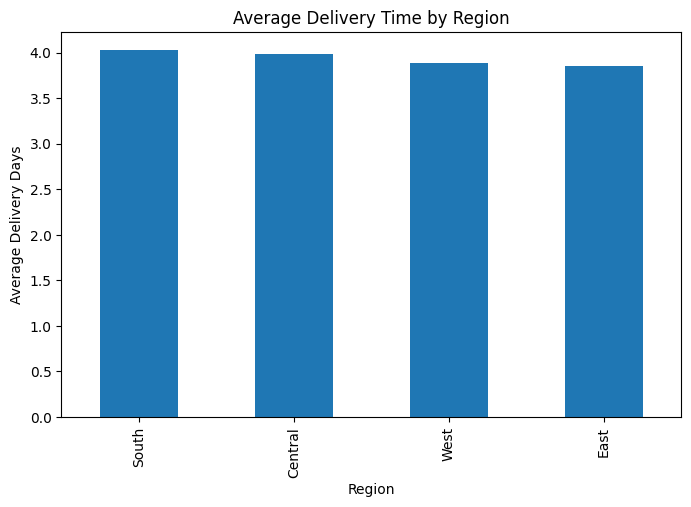

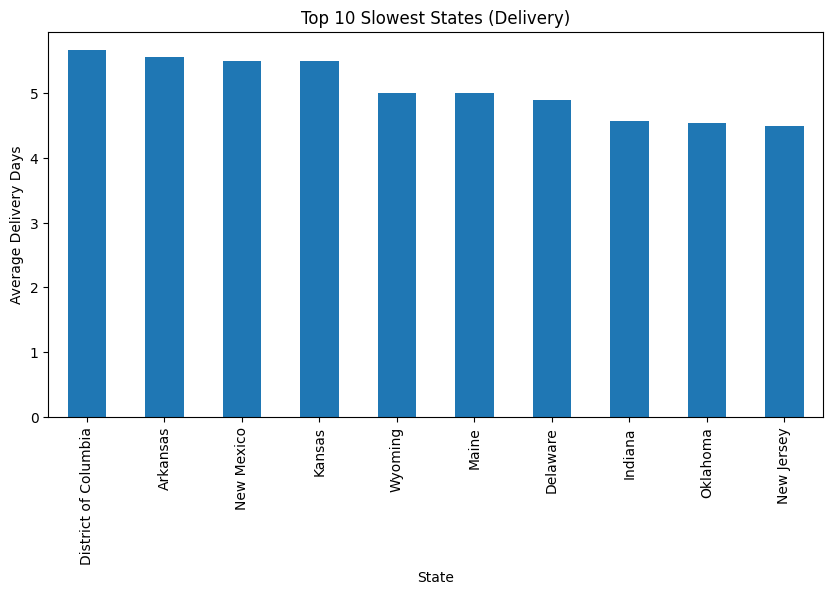

In [47]:

# By Region
region_delay.plot(kind='bar', figsize=(8,5), title='Average Delivery Time by Region')
plt.ylabel('Average Delivery Days')
plt.show()

# By State (Top 10 slowest)
state_delay.head(10).plot(kind='bar', figsize=(10,5), title='Top 10 Slowest States (Delivery)')
plt.ylabel('Average Delivery Days')
plt.show()


In [48]:
delayed_orders = df[df['Delivery_Days'] > df['Delivery_Days'].quantile(0.90)]
print(delayed_orders[['Order ID', 'City', 'State', 'Region', 'Delivery_Days']])


            Order ID             City           State   Region  Delivery_Days
2     US-2015-108966  Fort Lauderdale         Florida    South              7
44    CA-2015-146262           Medina            Ohio     East              7
46    CA-2015-163055          Detroit        Michigan  Central              7
99    CA-2016-109869          Phoenix         Arizona     West              7
100   CA-2016-109869          Phoenix         Arizona     West              7
...              ...              ...             ...      ...            ...
2042  CA-2014-124702          Seattle      Washington     West              7
2043  CA-2014-124702          Seattle      Washington     West              7
2049  CA-2014-156160    New York City        New York     East              7
2050  CA-2014-156160    New York City        New York     East              7
2083  US-2017-152842        Charlotte  North Carolina    South              7

[129 rows x 5 columns]


#### Delivery Time Statistics
The analysis of delivery time provides key insights into the efficiency and variability of the shipping process:

#### Overall Performance
The average delivery time across all orders is approximately 3.92 days, which suggests that most deliveries are completed within 4 business days.

The standard deviation of 1.76 days indicates moderate variation, meaning while many deliveries meet the average, there are still noticeable fluctuations in delivery times.

##### Regional Differences
East (3.85 days) had the fastest average delivery, followed closely by the West and Central regions.

South (4.02 days) had the slowest regional average, suggesting room for improvement in logistics or carrier performance in that area.

 This difference may impact customer satisfaction and should be considered when planning inventory or marketing strategies per region.

##### Delivery Delays in Specific Cities
Some cities consistently hit the maximum delivery time of 7 days, such as Norwich, Danbury, and Olathe.

These delays may be due to remote locations, poor logistics infrastructure, or carrier limitations.

 Such cities may benefit from localized distribution centers or priority shipping methods.

##### States with Longest Delivery Times
District of Columbia, Arkansas, New Mexico, Kansas, and Wyoming have average delivery days between 5–5.7 days—well above the dataset’s mean.

This highlights potential inefficiencies in delivery networks or geographical challenges in these states.

In [49]:
# profit by segemnt 

Segment
Corporate      7584.8158
Consumer       6991.0786
Home Office    3875.3784
Name: Profit, dtype: float64


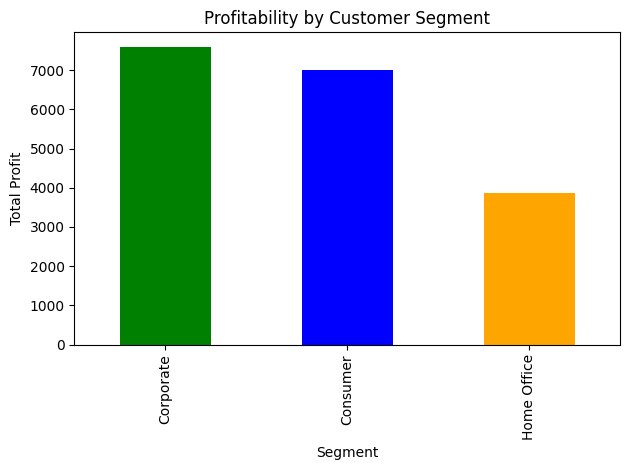

In [50]:
# Plot profit by customer segment 
segment_profit = df.groupby('Segment')['Profit'].sum().sort_values(ascending=False)
print(segment_profit)

segment_profit.plot(kind='bar', color=['green', 'blue', 'orange'])
plt.title('Profitability by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('Total Profit')
plt.tight_layout()
plt.show()



In [51]:
avg_profit_per_order = df.groupby('Segment')['Profit'].mean().sort_values(ascending=False)
print(avg_profit_per_order)


Segment
Corporate      11.741201
Home Office    10.705465
Consumer        6.281293
Name: Profit, dtype: float64


#### Profitability by Customer Segment
This bar chart visualizes total profit generated by each customer segment:

Corporate Segment leads in profitability, contributing the highest total profit among the three segments. This indicates strong performance and effective margin management in B2B sales.

Consumer Segment follows closely behind, also yielding a significant profit, suggesting healthy demand and pricing strategies in the general consumer market.

Home Office Segment generates the lowest profit, which could be due to:

Smaller order volumes,

Higher discounts or delivery costs,

Less frequent purchases compared to corporate clients.

#### Recommendations:
Focus marketing and retention strategies on Corporate and Consumer segments, as they drive the majority of profit.

Investigate profitability constraints in the Home Office segment—possibly optimize pricing, reduce discounts, or bundle products for better margins.

Use these insights to refine customer targeting and allocate resources efficiently across segments.

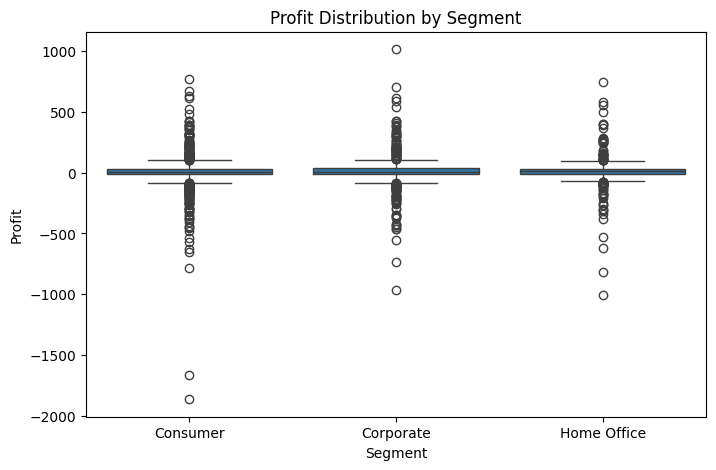

In [52]:
#plot of Distribution by Segment
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Segment', y='Profit')
plt.title('Profit Distribution by Segment')
plt.show()


#### Profit Distribution by Segment (Box Plot)
This box plot shows how profits are distributed across the three customer segments  Consumer, Corporate, and Home Office:

Corporate Segment:

Has the widest spread of profit values.

Shows higher upper outliers, suggesting it occasionally generates very large profits.

The median profit is slightly above that of the other segments, reinforcing its strong overall performance.

Consumer Segment:

Also displays a broad range of profits but with more negative outliers, suggesting higher variability in profitability.

The median is slightly lower than Corporate, with a heavier presence of small-loss transactions.

Home Office Segment:

Has a narrower interquartile range, indicating less variability in typical transactions.

However, like the others, it also shows many negative outliers, which may explain its lower total profitability (as seen in the previous bar chart).


Corporate clients may provide fewer risky transactions with high potential gain.

Consumer and Home Office segments should be examined for causes of frequent small or negative profits—this could be due to aggressive discounting or high fulfillment costs.

Targeted strategies like refined pricing or personalized offers could help reduce losses in underperforming segments.

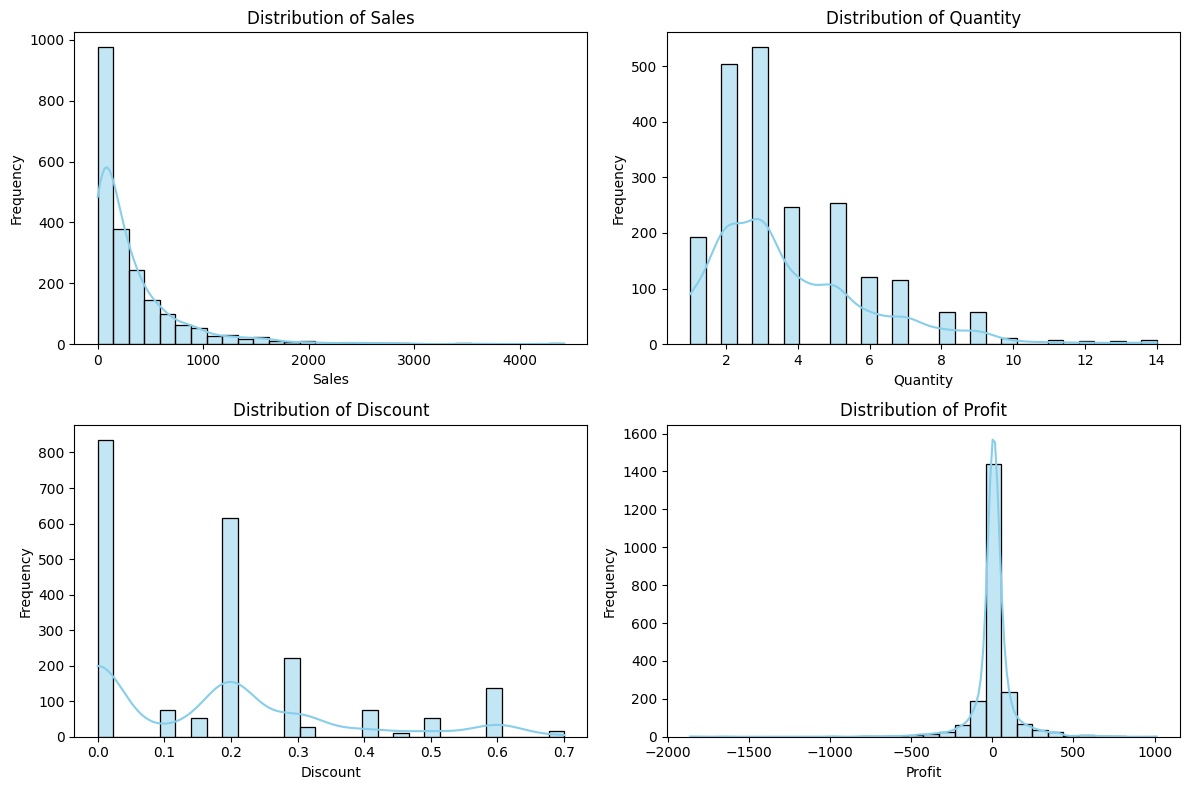

In [53]:
num_features = ['Sales', 'Quantity', 'Discount','Profit']

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Plot histograms for each numerical feature
for i, feature in enumerate(num_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

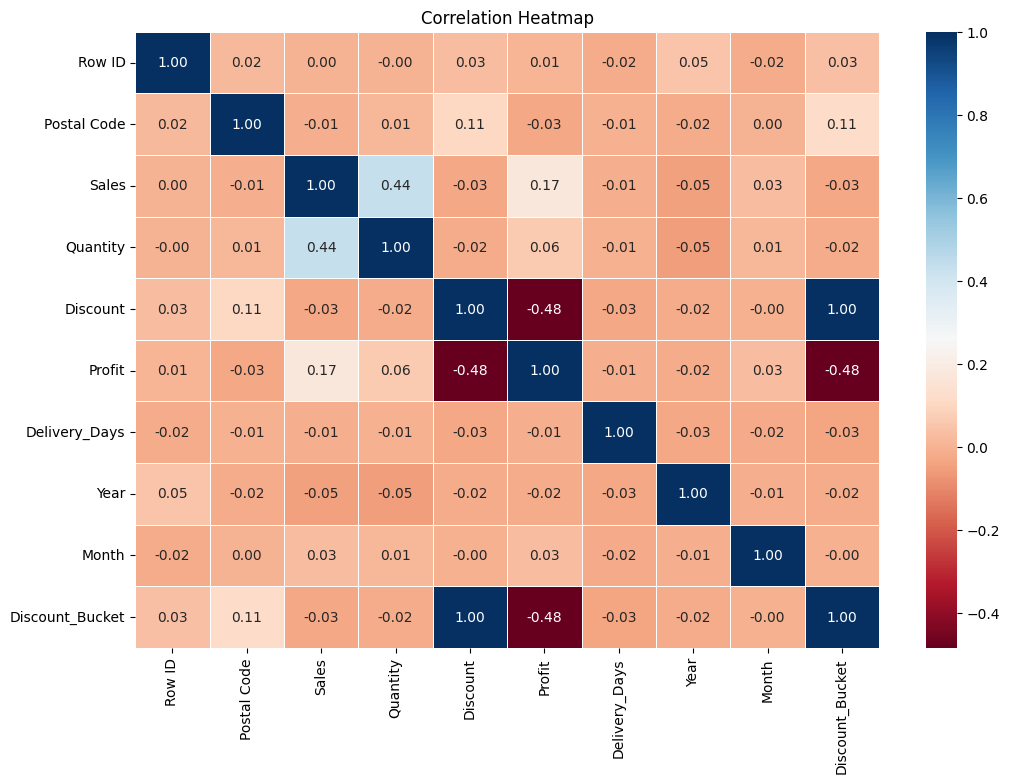

In [54]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### The Correlation Heatmap:
 Strongest Correlations:
Discount vs Profit: -0.48

This is the strongest negative correlation in the heatmap.

Insight: As the discount increases, profit significantly decreases. This supports earlier findings that excessive discounting harms profitability.

Discount Bucket vs Profit: -0.48

Similar to Discount, this shows that grouped discount levels are also inversely related to profit.

Sales vs Quantity: +0.44

Logical and expected: higher quantities sold generally lead to higher total sales.

##### Weak or Negligible Correlations:
Profit vs Sales: +0.17

Only a slight positive relationship; meaning higher sales don’t always lead to higher profit.

This reflects margin erosion, possibly due to discounts or high delivery costs.

Other Variables (Year, Month, Delivery Days):

All show correlations near 0, indicating little to no linear relationship with profit, sales, or discount directly.

Suggests that seasonality or delivery time has a weak direct impact on profit in this dataset.


Discounts are strongly negatively correlated with profit, confirming that aggressive discounting strategies reduce overall profitability. Meanwhile, more units sold increase sales, but sales alone don’t guarantee high profit — highlighting the importance of cost control and pricing strategy.

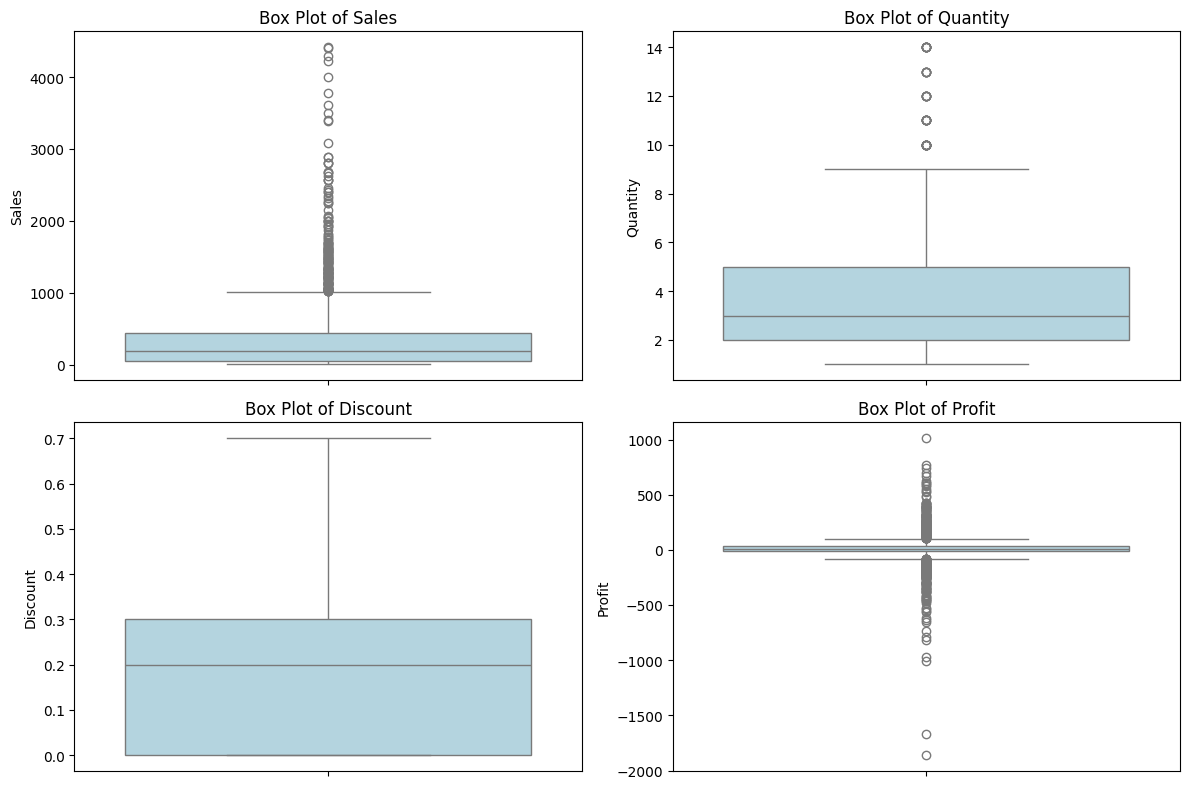

In [55]:
# Set up the plotting area
plt.figure(figsize=(12, 8))

# Plot simple box plots for each numerical feature
for i, feature in enumerate(num_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df[feature], color='lightblue')
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

#### Distribution Plots:
1. Distribution of Sales (Top Left)
The distribution is right-skewed.

Most sales transactions are of low value, clustered between 0–500.

There are a few outliers with very high sales amounts (above 2000), indicating occasional large orders.

2. Distribution of Quantity (Top Right)
Quantity sold per transaction peaks around 2–4 units.

It gradually tapers off, showing fewer transactions involving larger quantities.

Indicates that small-quantity purchases are much more frequent.

3. Distribution of Discount (Bottom Left)
The discount distribution is multi-modal:

Most orders receive no discount (0%), forming a strong peak.

Smaller peaks at 0.2, 0.3, 0.5, and 0.6 suggest specific discount tiers are frequently applied.

Suggests structured discount policies rather than random values.

4. Distribution of Profit (Bottom Right)
Profit is tightly centered around zero, with most values between -200 and +200.

There is a long left tail, meaning some transactions incur significant losses (below -1000).

Indicates the business has a high volume of low-profit sales, with occasional large losses.

**Summary**:
Sales and profit patterns reflect a low-margin, high-volume retail environment.

Most purchases are small, with limited discounts and profits, while a few high-discount cases significantly impact profitability.

Understanding these distributions is critical for pricing, discount, and inventory strategies.

# Prophet Forecasting.

## 📁 Model Continuation Notice

👉 **Note:** The model building and forecasting eels) has been continued in a separate notebook titled:

📄 **`model.ipynb`**

This was done to keep the exploratory analysis and model training organized and manageablve modeling phase**.
